# Comprehensive Spotify Music Trend Analysis (1920-2023)

This notebook presents a comprehensive analysis of music trends on Spotify from 1920 to 2023, integrating multiple datasets to provide deeper insights into genre evolution, artist success metrics, and audio feature patterns over time.

## 1. Setup and Data Loading

First, we'll set up our environment and load the necessary libraries for data processing and visualization.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import re
import warnings
warnings.filterwarnings('ignore')

# Import interactive visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", 10)  # Using viridis for better color perception
sns.set_palette(palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

# Configure visualization settings
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20

# Create directories for visualizations
os.makedirs('spotify_visualizations', exist_ok=True)

### 1.1 Configure Kaggle API

We'll set up the Kaggle API to access the Spotify datasets.

In [ ]:
# Configure Kaggle API
kaggle_username = "devactk"
kaggle_key = "a82cf428af27572938774b1ffea04f68"

# Kaggle API configuration
!mkdir -p ~/.kaggle
!echo '{"username":"'$kaggle_username'","key":"'$kaggle_key'"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

### 1.2 Download Spotify Datasets

We'll download all four Spotify datasets from Kaggle.

In [ ]:
!mkdir -p spotify_data

# Datasets
!kaggle datasets download rodolfofigueroa/spotify-12m-songs -p spotify_data
!kaggle datasets download nelgiriyewithana/top-spotify-songs-2023 -p spotify_data
!kaggle datasets download joebeachcapital/30000-spotify-songs -p spotify_data
!kaggle datasets download yamaerenay/spotify-dataset-19212020-600k-tracks -p spotify_data

# Extract
!cd spotify_data && unzip -o "*.zip"

Dataset URL: https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023
License(s): other
Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs
License(s): DbCL-1.0
Dataset URL: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks
License(s): Community Data License Agreement - Sharing - Version 1.0
Archive:  30000-spotify-songs.zip
  inflating: readme.md               
  inflating: spotify_songs.csv       

Archive:  spotify-dataset-19212020-600k-tracks.zip
  inflating: artists.csv             
  inflating: dict_artists.json       
  inflating: tracks.csv              

Archive:  top-spotify-songs-2023.zip
  inflating: spotify-2023.csv        

Archive:  spotify-12m-songs.zip
  inflating: tracks_features.csv     

4 archives were successfully processed.


### 1.3 Function to Safely Read CSV Files

We'll define a function to safely read CSV files with different encodings.

In [ ]:
def safe_read_csv(file_path, nrows=None, low_memory=False):
    """Safely read CSV files with different encodings."""
    encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']

    for encoding in encodings:
        try:
            if nrows:
                return pd.read_csv(file_path, encoding=encoding, nrows=nrows, low_memory=low_memory)
            else:
                return pd.read_csv(file_path, encoding=encoding, low_memory=low_memory)
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"Error reading {file_path} with {encoding} encoding: {str(e)}")

    print(f"Failed to read {file_path} with any encoding")
    return None

### 1.4 Load All Datasets

Now we'll load all four datasets for integration and analysis.

In [ ]:
# Load 30,000 Spotify Songs dataset
spotify_30k_df = safe_read_csv('spotify_data/spotify_songs.csv')
print(f"Loaded 30,000 Spotify Songs dataset: {spotify_30k_df.shape}")

# Load tracks dataset from 600k tracks collection
tracks_df = safe_read_csv('spotify_data/tracks.csv', low_memory=True)
print(f"Loaded tracks dataset: {tracks_df.shape}")

# Load artists dataset from 600k tracks collection
artists_df = safe_read_csv('spotify_data/artists.csv')
print(f"Loaded artists dataset: {artists_df.shape}")

# Load top songs 2023 dataset
top2023_df = safe_read_csv('spotify_data/spotify-2023.csv')
print(f"Loaded top songs 2023 dataset: {top2023_df.shape}")

# Load 1.2M songs dataset (using a sample for initial processing)
tracks_features_df = safe_read_csv('spotify_data/tracks_features.csv', nrows=500000, low_memory=True)
print(f"Loaded tracks features dataset sample: {tracks_features_df.shape}")

Loaded 30,000 Spotify Songs dataset: (32833, 23)
Loaded tracks dataset: (586672, 20)
Loaded artists dataset: (1162095, 5)
Loaded top songs 2023 dataset: (953, 24)
Loaded tracks features dataset sample: (500000, 24)


## 2. Data Exploration and Preprocessing

Let's explore the datasets and perform necessary preprocessing before integration.

In [ ]:
# Display information about the datasets
print("\n30,000 Spotify Songs Dataset Columns:")
print(spotify_30k_df.columns.tolist())

print("\nTracks Dataset Columns:")
print(tracks_df.columns.tolist())

print("\nTop 2023 Songs Dataset Columns:")
print(top2023_df.columns.tolist())

print("\nTracks Features Dataset Columns:")
print(tracks_features_df.columns.tolist())


30,000 Spotify Songs Dataset Columns:
['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

Tracks Dataset Columns:
['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists', 'id_artists', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

Top 2023 Songs Dataset Columns:
['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', '

### 2.1 Data Cleaning and Standardization

We'll define functions to clean and standardize the datasets before integration.

In [ ]:
def clean_and_standardize_30k(df):
    """Clean and standardize the 30,000 Spotify Songs dataset."""
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Standardize column names
    column_mapping = {
        'track_id': 'id',
        'track_name': 'name',
        'track_artist': 'artists',
        'track_popularity': 'popularity',
        'track_album_id': 'album_id',
        'track_album_name': 'album',
        'track_album_release_date': 'release_date'
    }

    # Rename columns
    df_clean = df_clean.rename(columns=column_mapping)

    # Extract year from release_date
    df_clean['year'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year

    # Add source column
    df_clean['source'] = '30k_songs'

    # Add decade column
    df_clean['decade'] = (df_clean['year'] // 10) * 10

    # Convert artists to list format if it's not already
    if df_clean['artists'].dtype == 'object':
        df_clean['artists_list'] = df_clean['artists'].apply(lambda x: [x] if isinstance(x, str) else x)

    # Extract primary genre from playlist_genre
    df_clean['primary_genre'] = df_clean['playlist_genre']

    return df_clean

def clean_and_standardize_tracks(df):
    """Clean and standardize the tracks dataset from 600k collection."""
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Convert release_date to datetime and extract year
    df_clean['year'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year

    # Add source column
    df_clean['source'] = '600k_tracks'

    # Add decade column
    df_clean['decade'] = (df_clean['year'] // 10) * 10

    # Convert artists from string representation to list
    if 'artists' in df_clean.columns and df_clean['artists'].dtype == 'object':
        df_clean['artists_list'] = df_clean['artists'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [x])

    return df_clean

def clean_and_standardize_top2023(df):
    """Clean and standardize the top 2023 songs dataset."""
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Standardize column names
    column_mapping = {
        'track_name': 'name',
        'artist(s)_name': 'artists',
        'released_year': 'year',
        'streams': 'stream_count',
        'danceability_%': 'danceability',
        'valence_%': 'valence',
        'energy_%': 'energy',
        'acousticness_%': 'acousticness',
        'instrumentalness_%': 'instrumentalness',
        'liveness_%': 'liveness',
        'speechiness_%': 'speechiness'
    }

    # Rename columns
    df_clean = df_clean.rename(columns=column_mapping)

    # Convert percentage values to decimal (0-1 scale)
    for col in ['danceability', 'valence', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']:
        if col in df_clean.columns:
            # First ensure the column is numeric
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            # Then perform the division
            df_clean[col] = df_clean[col] / 100

    # Add source column
    df_clean['source'] = 'top_2023'

    # Add decade column
    df_clean['decade'] = (df_clean['year'] // 10) * 10

    # Convert artists to list
    df_clean['artists_list'] = df_clean['artists'].apply(lambda x: [a.strip() for a in str(x).split(',')] if isinstance(x, str) else [str(x)])

    # Create a synthetic popularity score based on streams and playlist presence
    if 'stream_count' in df_clean.columns and 'in_spotify_playlists' in df_clean.columns:
        # Ensure columns are numeric
        df_clean['stream_count'] = pd.to_numeric(df_clean['stream_count'], errors='coerce')
        df_clean['in_spotify_playlists'] = pd.to_numeric(df_clean['in_spotify_playlists'], errors='coerce')

        # Normalize streams to 0-100 scale
        max_streams = df_clean['stream_count'].max()
        max_playlists = df_clean['in_spotify_playlists'].max()

        # Avoid division by zero
        if max_streams > 0 and max_playlists > 0:
            df_clean['popularity'] = (df_clean['stream_count'] / max_streams * 70) + \
                                    (df_clean['in_spotify_playlists'] / max_playlists * 30)
            df_clean['popularity'] = df_clean['popularity'].clip(0, 100)

    return df_clean

def clean_and_standardize_tracks_features(df):
    """Clean and standardize the tracks features dataset from 1.2M collection."""
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Add source column
    df_clean['source'] = '1.2m_tracks'

    # Ensure year is numeric
    df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce')

    # Add decade column
    df_clean['decade'] = (df_clean['year'] // 10) * 10

    # Convert artists from string representation to list
    if 'artists' in df_clean.columns and df_clean['artists'].dtype == 'object':
        df_clean['artists_list'] = df_clean['artists'].apply(
            lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [str(x)])

    return df_clean

### 2.2 Apply Cleaning and Standardization

In [ ]:
# Apply cleaning and standardization to each dataset
spotify_30k_clean = clean_and_standardize_30k(spotify_30k_df)
tracks_clean = clean_and_standardize_tracks(tracks_df)
top2023_clean = clean_and_standardize_top2023(top2023_df)
tracks_features_clean = clean_and_standardize_tracks_features(tracks_features_df)

# Display the first few rows of each cleaned dataset
print("\nCleaned 30,000 Spotify Songs Dataset:")
display(spotify_30k_clean.head(2))

print("\nCleaned Tracks Dataset:")
display(tracks_clean.head(2))

print("\nCleaned Top 2023 Songs Dataset:")
display(top2023_clean.head(2))

print("\nCleaned Tracks Features Dataset:")
display(tracks_features_clean.head(2))


Cleaned 30,000 Spotify Songs Dataset:


,id,name,artists,popularity,album_id,album,release_date,playlist_name,playlist_id,playlist_genre,...,instrumentalness,liveness,valence,tempo,duration_ms,year,source,decade,artists_list,primary_genre
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.00000,0.0653,0.518,122.036,194754,2019.0,30k_songs,2010.0,[Ed Sheeran],pop
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0.00421,0.3570,0.693,99.972,162600,2019.0,30k_songs,2010.0,[Maroon 5],pop



Cleaned Tracks Dataset:


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,source,decade,artists_list
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.445,...,0.674,0.744,0.151,0.127,104.851,3,1922.0,600k_tracks,1920.0,[Uli]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.263,...,0.797,0.000,0.148,0.655,102.009,1,1922.0,600k_tracks,1920.0,[Fernando Pessoa]



Cleaned Top 2023 Songs Dataset:


,name,artists,artist_count,year,released_month,released_day,in_spotify_playlists,in_spotify_charts,stream_count,in_apple_playlists,...,valence,energy,acousticness,instrumentalness,liveness,speechiness,source,decade,artists_list,popularity
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,0.89,0.83,0.31,0.0,0.08,0.04,top_2023,2020,"[Latto, Jung Kook]",2.985599
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,0.61,0.74,0.07,0.0,0.10,0.04,top_2023,2020,[Myke Towers],3.363056



Cleaned Tracks Features Dataset:


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,liveness,valence,tempo,duration_ms,time_signature,year,release_date,source,decade,artists_list
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.356,0.503,117.906,210133,4.0,1999,1999-11-02,1.2m_tracks,1990,[Rage Against The Machine]
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.155,0.489,103.680,206200,4.0,1999,1999-11-02,1.2m_tracks,1990,[Rage Against The Machine]


## 3. Data Integration

Now we'll integrate the datasets according to our strategy.

### 3.1 Define Common Audio Features

In [ ]:
# Define common audio features across datasets
audio_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

# Define common metadata fields
metadata_fields = [
    'id', 'name', 'popularity', 'year', 'decade', 'release_date',
    'artists', 'artists_list', 'album', 'duration_ms', 'source'
]

### 3.2 Create Unified Tracks Dataset

In [ ]:
def create_unified_tracks_dataset(df_list, id_column='id'):
    """Create a unified tracks dataset from multiple sources."""
    # Start with an empty DataFrame
    unified_df = pd.DataFrame()

    # Process each dataset
    for df in df_list:
        # Skip empty DataFrames
        if df is None or df.empty:
            continue

        # Ensure id column exists
        if id_column not in df.columns:
            print(f"Warning: {id_column} column not found in dataset with columns {df.columns.tolist()}")
            continue

        # Select relevant columns that exist in this dataset
        available_features = [col for col in audio_features if col in df.columns]
        available_metadata = [col for col in metadata_fields if col in df.columns]

        # Select columns
        selected_columns = available_metadata + available_features
        df_selected = df[selected_columns].copy()

        # If unified_df is empty, use this dataset as the base
        if unified_df.empty:
            unified_df = df_selected
        else:
            # Append new tracks (not already in unified_df)
            existing_ids = set(unified_df[id_column]) if id_column in unified_df.columns else set()
            new_tracks = df_selected[~df_selected[id_column].isin(existing_ids)]

            # For tracks already in unified_df, update with more recent or detailed data
            # This is a simplified approach - in a real scenario, you might want more sophisticated merging logic
            common_tracks = df_selected[df_selected[id_column].isin(existing_ids)]

            # Append new tracks
            unified_df = pd.concat([unified_df, new_tracks], ignore_index=True)

    return unified_df

# Create unified tracks dataset
# We'll use tracks with IDs from all datasets except top2023 which doesn't have track IDs
unified_tracks = create_unified_tracks_dataset([tracks_features_clean, tracks_clean, spotify_30k_clean])

# For top2023, we'll try to match by name and artist
if not top2023_clean.empty and 'name' in top2023_clean.columns and 'artists' in top2023_clean.columns:
    # Create a temporary key for matching
    top2023_clean['temp_key'] = top2023_clean['name'].str.lower() + ' - ' + top2023_clean['artists'].astype(str).str.lower()
    unified_tracks['temp_key'] = unified_tracks['name'].str.lower() + ' - ' + unified_tracks['artists'].astype(str).str.lower()

    # Find tracks in top2023 that don't match any in unified_tracks
    existing_keys = set(unified_tracks['temp_key'])
    new_top2023_tracks = top2023_clean[~top2023_clean['temp_key'].isin(existing_keys)]

    # Generate synthetic IDs for these tracks
    if not new_top2023_tracks.empty:
        new_top2023_tracks['id'] = ['top2023_' + str(i) for i in range(len(new_top2023_tracks))]

        # Select relevant columns
        available_features = [col for col in audio_features if col in new_top2023_tracks.columns]
        available_metadata = [col for col in metadata_fields if col in new_top2023_tracks.columns]
        selected_columns = available_metadata + available_features

        # Append to unified_tracks
        unified_tracks = pd.concat([unified_tracks, new_top2023_tracks[selected_columns]], ignore_index=True)

    # Clean up temporary keys
    unified_tracks = unified_tracks.drop('temp_key', axis=1)

# Display information about the unified tracks dataset
print(f"Unified tracks dataset shape: {unified_tracks.shape}")
print(f"Number of unique tracks: {unified_tracks['id'].nunique()}")
print(f"Year range: {unified_tracks['year'].min()} - {unified_tracks['year'].max()}")
print(f"Decade distribution:\n{unified_tracks['decade'].value_counts().sort_index()}")
print(f"Source distribution:\n{unified_tracks['source'].value_counts()}")

Unified tracks dataset shape: (1098226, 22)
Number of unique tracks: 1096478
Year range: 1900.0 - 2023.0
Decade distribution:
decade
1900.0        59
1910.0        19
1920.0      3354
1930.0      6075
1940.0      9639
1950.0     21503
1960.0     34024
1970.0     48027
1980.0     70306
1990.0    166014
2000.0    321798
2010.0    255813
2020.0     26621
Name: count, dtype: int64
Source distribution:
source
600k_tracks    575329
1.2m_tracks    500000
30k_songs       21984
top_2023          913
Name: count, dtype: int64


### 3.3 Create Temporal Trends Dataset

In [ ]:
# ————————————————
# 1) Audio feature list
audio_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# ————————————————
# 2) Temporal trend creator function
def create_temporal_trends_dataset(tracks_df, group_by='decade'):
    """Create a dataset for temporal trend analysis, sadece sayısal sütunları kullanarak."""
    if group_by not in tracks_df.columns:
        print(f"Warning: {group_by} column not found in dataset")
        return None

    # take numerical columns from audio_features
    numeric_feats = [
        feat for feat in audio_features
        if feat in tracks_df.columns and pd.api.types.is_numeric_dtype(tracks_df[feat])
    ]

    agg_dict = {feat: ['mean', 'median', 'std'] for feat in numeric_feats}
    if 'popularity' in tracks_df.columns and pd.api.types.is_numeric_dtype(tracks_df['popularity']):
        agg_dict['popularity'] = ['mean', 'median', 'std', 'count']
    else:
        agg_dict['popularity'] = ['count']

    trends_df = tracks_df.groupby(group_by).agg(agg_dict)
    trends_df.columns = ['_'.join(col) for col in trends_df.columns.values]
    return trends_df.reset_index()

# ————————————————
# 3) Making sure year, decade, key ve mode are in correct type
for df in [spotify_30k_clean, tracks_clean, top2023_clean, tracks_features_clean]:
    # year yoksa release_date’dan çıkar
    if 'year' not in df.columns and 'release_date' in df.columns:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
        df['year'] = df['release_date'].dt.year
    # add decade
    df['decade'] = (df['year'] // 10) * 10
    # key ve mode to numeric
    for c in ('key','mode'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')


# Create temporal trends dataset by decade
decade_trends = create_temporal_trends_dataset(unified_tracks, 'decade')

# Create temporal trends dataset by year (for more recent years with more data)
# Filter to years with sufficient data
recent_tracks = unified_tracks[unified_tracks['year'] >= 1950].copy()
year_trends = create_temporal_trends_dataset(recent_tracks, 'year')

# Display decade trends
print("Decade Trends:")
display(decade_trends.sort_values('decade'))

Decade Trends:


,decade,danceability_mean,danceability_median,danceability_std,energy_mean,energy_median,energy_std,loudness_mean,loudness_median,loudness_std,...,tempo_mean,tempo_median,tempo_std,duration_ms_mean,duration_ms_median,duration_ms_std,popularity_mean,popularity_median,popularity_std,popularity_count
0,1900.0,0.582203,0.584,0.123311,0.438337,0.440,0.194126,-14.587034,-13.8490,3.598218,...,122.840847,118.9040,31.985279,269773.559322,193573.0,148735.894629,19.000000,19.0,NaN,1
1,1910.0,0.438211,0.454,0.211571,0.160849,0.126,0.111608,-19.751368,-18.6520,4.221692,...,116.422000,117.6980,34.883313,238492.631579,186987.0,112457.852855,NaN,NaN,NaN,0
2,1920.0,0.627352,0.671,0.152481,0.251431,0.237,0.127128,-16.082738,-16.7660,4.907901,...,110.501695,112.7365,30.542909,174308.028324,169313.5,58736.445363,0.080868,0.0,0.800384,3042
3,1930.0,0.548080,0.570,0.157063,0.289989,0.256,0.161198,-14.278112,-13.1220,5.624531,...,110.457112,110.8005,31.173512,201660.919164,182602.5,183898.344876,1.128301,0.0,4.149936,5876
4,1940.0,0.505733,0.509,0.156455,0.286855,0.255,0.170053,-12.801445,-12.2500,4.403470,...,106.588394,102.2580,32.209161,209363.772855,187495.0,179873.811063,1.195522,0.0,3.979077,9304
5,1950.0,0.496687,0.507,0.162736,0.317438,0.284,0.200441,-13.851616,-13.1160,5.296358,...,111.557315,108.4940,31.039931,212984.037778,185467.0,145778.230958,8.578182,5.0,10.251528,20014
6,1960.0,0.494891,0.502,0.158847,0.416242,0.401,0.220287,-12.364128,-11.5040,5.137621,...,114.260794,111.5950,29.288553,209692.934393,178333.0,149943.220730,17.942483,16.0,13.035617,30135
7,1970.0,0.513901,0.518,0.158927,0.494333,0.489,0.229518,-11.734218,-11.0455,4.731305,...,116.880812,115.3530,28.874590,236331.268294,210173.0,148629.700384,23.882292,23.0,13.688179,41025
8,1980.0,0.543087,0.564,0.170999,0.525567,0.528,0.252991,-12.030817,-11.2460,5.413597,...,118.019346,117.0130,29.529650,235731.024055,225307.0,128104.207670,25.252878,25.0,13.266021,57859
9,1990.0,0.516413,0.532,0.186058,0.493473,0.500,0.283144,-12.705935,-11.0620,6.705591,...,117.162675,114.8520,30.728184,247991.055108,231867.0,138243.292024,29.332258,29.0,13.545440,82103


### 3.4 Create Genre Analysis Dataset

In [ ]:
def extract_genres(tracks_df):
    """Extract and standardize genre information from tracks dataset."""
    # Start with an empty genre dataset
    genre_df = pd.DataFrame()

    # Check if we have playlist_genre in the 30k dataset
    if 'playlist_genre' in tracks_df.columns:
        # Extract tracks with genre information
        genre_tracks = tracks_df[tracks_df['playlist_genre'].notna()].copy()

        # Group by genre and aggregate audio features
        agg_features = [col for col in audio_features if col in genre_tracks.columns]
        agg_dict = {feature: 'mean' for feature in agg_features}
        agg_dict['popularity'] = ['mean', 'count'] if 'popularity' in genre_tracks.columns else 'count'

        # Group by genre
        genre_df = genre_tracks.groupby('playlist_genre').agg(agg_dict)

        # Flatten multi-level columns if necessary
        if isinstance(genre_df.columns, pd.MultiIndex):
            genre_df.columns = ['_'.join(col).strip() for col in genre_df.columns.values]

        # Reset index
        genre_df = genre_df.reset_index().rename(columns={'playlist_genre': 'genre'})

        # Add subgenre information if available
        if 'playlist_subgenre' in genre_tracks.columns:
            # Group tracks by genre and subgenre
            subgenre_counts = genre_tracks.groupby(['playlist_genre', 'playlist_subgenre']).size().reset_index()
            subgenre_counts.columns = ['genre', 'subgenre', 'count']

            # Find the most common subgenres for each genre
            top_subgenres = subgenre_counts.sort_values('count', ascending=False).groupby('genre').head(3)

            # Create a dictionary mapping genres to their top subgenres
            genre_to_subgenres = {}
            for genre in top_subgenres['genre'].unique():
                subgenres = top_subgenres[top_subgenres['genre'] == genre]['subgenre'].tolist()
                genre_to_subgenres[genre] = subgenres

            # Add top subgenres to genre_df
            genre_df['top_subgenres'] = genre_df['genre'].map(genre_to_subgenres)

    return genre_df

# Create genre analysis dataset
genre_analysis = extract_genres(spotify_30k_clean)

# Display genre analysis
print("Genre Analysis:")
display(genre_analysis.sort_values('popularity_mean', ascending=False).head(10))

Genre Analysis:


,genre,danceability_mean,energy_mean,key_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,instrumentalness_mean,liveness_mean,valence_mean,tempo_mean,duration_ms_mean,popularity_mean,popularity_count,top_subgenres
2,pop,0.639302,0.701028,5.318867,-6.315328,0.588161,0.073991,0.170794,0.059876,0.176833,0.503521,120.743178,217768.104231,47.744870,5507,"[indie poptimism, electropop, dance pop]"
1,latin,0.713287,0.708312,5.483996,-6.264455,0.561979,0.102653,0.210920,0.044447,0.180626,0.605510,118.622354,216863.446945,47.026576,5155,"[latin hip hop, tropical, latin pop]"
4,rap,0.718353,0.650708,5.470936,-7.042269,0.521406,0.197506,0.192479,0.075997,0.191654,0.505090,120.654908,214163.889140,43.215454,5746,"[southern hip hop, gangster rap, hip hop]"
5,rock,0.520548,0.732813,5.209049,-7.588895,0.700263,0.057696,0.145189,0.062417,0.203135,0.537352,124.988786,248576.500303,41.728338,4951,"[hard rock, classic rock, permanent wave]"
3,r&b,0.670179,0.590934,5.400479,-7.864848,0.521451,0.116792,0.259904,0.028920,0.175268,0.531231,114.222156,237599.489781,41.223532,5431,"[neo soul, urban contemporary, hip pop]"
0,edm,0.655041,0.802476,5.352143,-5.427445,0.520106,0.086695,0.081504,0.218578,0.211859,0.400656,125.768024,222540.858349,34.833526,6043,"[progressive electro house, pop edm, electro h..."


## 4. Trend Analysis

Now that we have integrated datasets, let's analyze trends over time.

### 4.1 Audio Feature Trends Over Time

In [ ]:
# Audio features statistics
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode',
                 'speechiness', 'acousticness', 'instrumentalness',
                 'liveness', 'valence', 'tempo']

available_features = [feat for feat in audio_features if feat in spotify_30k_df.columns]

if available_features:
    # Display statistics
    print("Audio Features Statistics:")
    print(spotify_30k_df[available_features].describe())

Audio Features Statistics:
       danceability        energy           key      loudness          mode  \
count  32833.000000  32833.000000  32833.000000  32833.000000  32833.000000   
mean       0.654850      0.698619      5.374471     -6.719499      0.565711   
std        0.145085      0.180910      3.611657      2.988436      0.495671   
min        0.000000      0.000175      0.000000    -46.448000      0.000000   
25%        0.563000      0.581000      2.000000     -8.171000      0.000000   
50%        0.672000      0.721000      6.000000     -6.166000      1.000000   
75%        0.761000      0.840000      9.000000     -4.645000      1.000000   
max        0.983000      1.000000     11.000000      1.275000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  32833.000000  32833.000000      32833.000000  32833.000000   
mean       0.107068      0.175334          0.084747      0.190176   
std        0.101314      0.219633          0.224230   

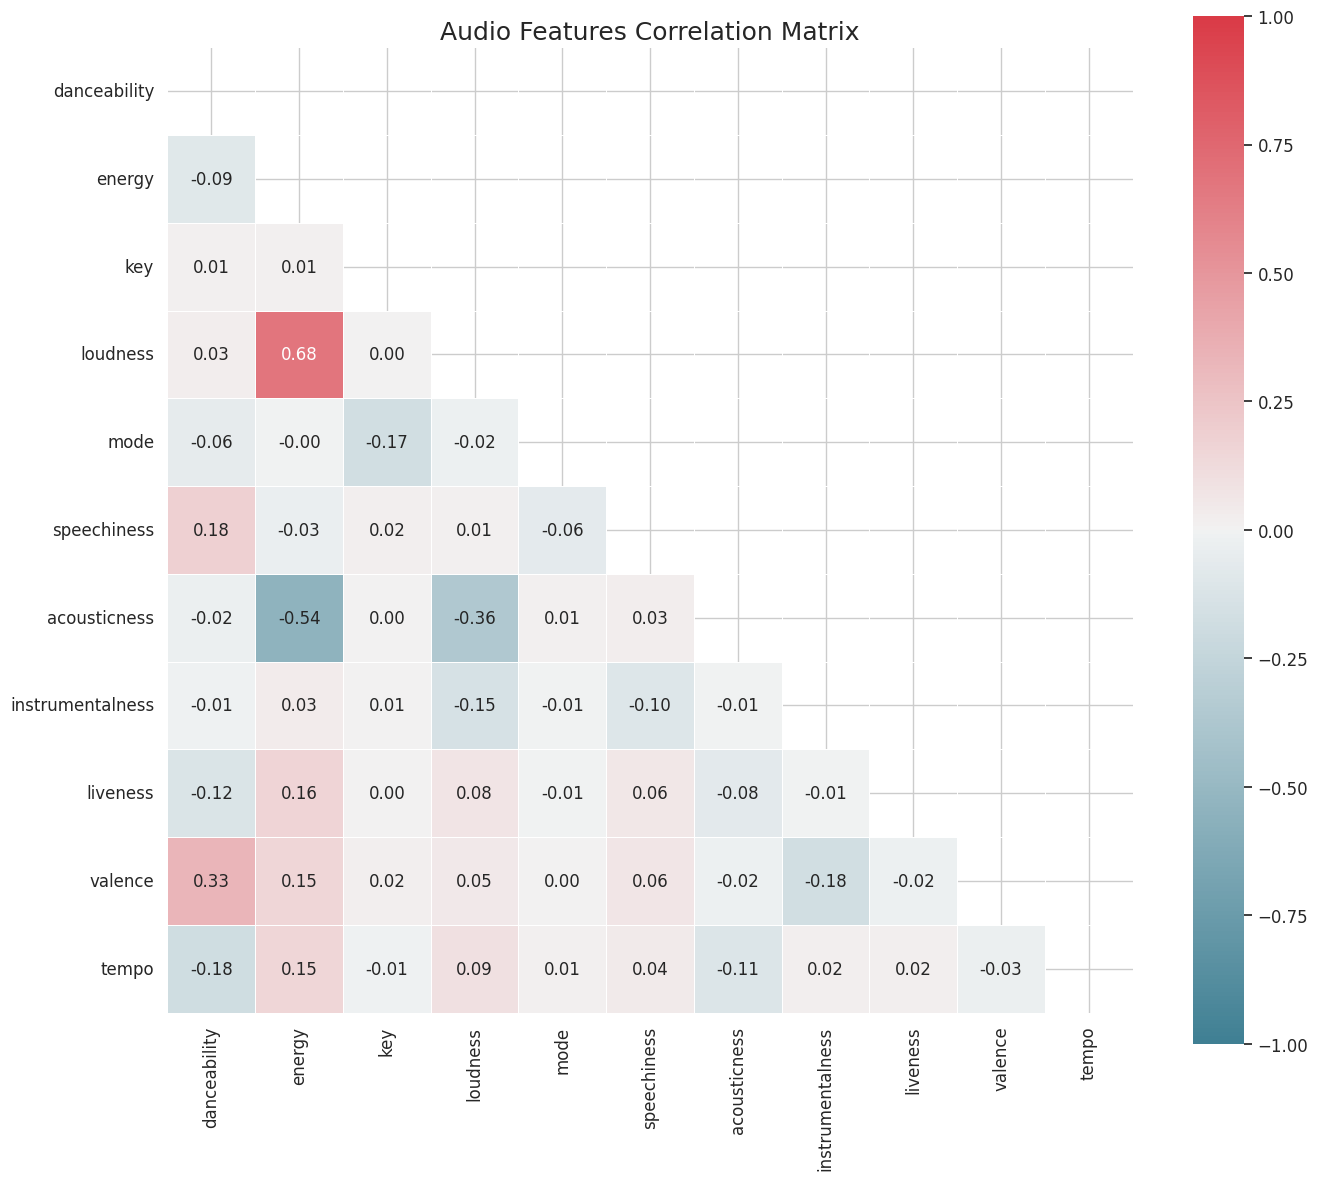

In [ ]:
# Correlation between audio features
if available_features:
    # Calculate correlation matrix
    correlation_matrix = spotify_30k_df[available_features].corr()

    # Create enhanced heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create mask for upper triangle

    # Custom colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Plot heatmap
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5)

    plt.title('Audio Features Correlation Matrix', fontsize=18)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot audio feature trends by decade
def plot_audio_feature_trends(trends_df, time_column='decade', normalize=True):
    """Plot trends in audio features over time, optionally normalized."""

    # Select mean columns for audio features (exclude popularity)
    feature_cols = [col for col in trends_df.columns if col.endswith('_mean') and not col.startswith('popularity')]

    # Extract relevant data
    plot_df = trends_df[[time_column] + feature_cols].copy()

    # Normalize each feature column to range [0, 1] (optional)
    if normalize:
        for col in feature_cols:
            min_val = plot_df[col].min()
            max_val = plot_df[col].max()
            if max_val != min_val:
                plot_df[col] = (plot_df[col] - min_val) / (max_val - min_val)
            else:
                plot_df[col] = 0  # constant value column

    # Melt the DataFrame to long format
    plot_df = pd.melt(plot_df, id_vars=[time_column], value_vars=feature_cols,
                      var_name='Feature', value_name='Value')

    # Clean feature names
    plot_df['Feature'] = plot_df['Feature'].str.replace('_mean', '')

    # Create interactive plot
    fig = px.line(plot_df, x=time_column, y='Value', color='Feature',
                 title=f'Audio Feature Trends by {time_column.capitalize()}{" (Normalized)" if normalize else ""}',
                 labels={time_column: time_column.capitalize(), 'Value': 'Normalized Value' if normalize else 'Average Value'},
                 template='plotly_white',
                 color_discrete_sequence=px.colors.qualitative.Bold,
                 line_shape='spline',
                 markers=True)

    # Update layout
    fig.update_layout(
        xaxis_title=time_column.capitalize(),
        yaxis_title='Normalized Value' if normalize else 'Average Value',
        legend_title='Audio Feature',
        height=600,
        width=1000,
        font=dict(family="Arial, sans-serif", size=14),
        title=dict(font=dict(size=20)),
        legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.2,  # move legend below the plot
                xanchor="center",
                x=0.5
            ),
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white'
    )

    # Update trace styling
    fig.update_traces(line=dict(width=3), marker=dict(size=8))

    # Add grid lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    return fig


# Plot decade trends
decade_trends_fig = plot_audio_feature_trends(decade_trends)
decade_trends_fig.show()

# Plot year trends for recent years
# Filter to years with sufficient data
recent_year_trends = year_trends[year_trends['popularity_count'] > 100].copy()
year_trends_fig = plot_audio_feature_trends(recent_year_trends, 'year')
year_trends_fig.show()

### 4.2 Popularity Trends Over Time

In [ ]:
# Plot popularity trends by decade
def plot_popularity_trends(trends_df, time_column='decade'):
    """Plot trends in popularity over time."""
    # Check if popularity columns exist
    if 'popularity_mean' not in trends_df.columns:
        print("Warning: popularity_mean column not found in trends dataset")
        return None

    # Create figure with enhanced styling
    fig = go.Figure()

    # Add mean popularity line with enhanced styling
    fig.add_trace(go.Scatter(
        x=trends_df[time_column],
        y=trends_df['popularity_mean'],
        mode='lines+markers',
        name='Mean Popularity',
        line=dict(color='#1f77b4', width=4, shape='spline'),
        marker=dict(size=10, symbol='circle', line=dict(width=2, color='white')),
        hovertemplate='%{x}: %{y:.1f}'
    ))

    # Add track count bars with enhanced styling
    fig.add_trace(go.Bar(
        x=trends_df[time_column],
        y=trends_df['popularity_count'],
        name='Number of Tracks',
        yaxis='y2',
        marker=dict(
            color='rgba(0, 128, 0, 0.7)',
            line=dict(color='rgba(0, 128, 0, 1.0)', width=1)
        ),
        hovertemplate='%{x}: %{y:,} tracks'
    ))

    # Update layout with enhanced styling
    fig.update_layout(
        title={
            'text': f'Popularity Trends by {time_column.capitalize()}',
            'font': dict(size=22, family='Arial, sans-serif'),
            'y': 0.95
        },
        xaxis=dict(
            title=time_column.capitalize(),
            titlefont=dict(size=16),
            tickfont=dict(size=14),
            showgrid=True,
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Mean Popularity',
            titlefont=dict(color='#1f77b4', size=16),
            tickfont=dict(color='#1f77b4', size=14),
            showgrid=True,
            gridcolor='lightgray'
        ),
        yaxis2=dict(
            title='Number of Tracks',
            titlefont=dict(color='green', size=16),
            tickfont=dict(color='green', size=14),
            anchor='x',
            overlaying='y',
            side='right'
        ),
        height=600,
        width=1000,
        template='plotly_white',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font=dict(size=14)
        ),
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white'
    )

    return fig

# Plot decade popularity trends
decade_popularity_fig = plot_popularity_trends(decade_trends)
decade_popularity_fig.show()

# Plot year popularity trends for recent years
year_popularity_fig = plot_popularity_trends(recent_year_trends, 'year')
year_popularity_fig.show()

### 4.3 Genre Popularity Over Time

In [ ]:
# Analyze genre trends over time
def analyze_genre_trends(tracks_df):
    """Analyze how genres have evolved in popularity over time."""
    # Check if we have the necessary columns
    if 'playlist_genre' not in tracks_df.columns or 'decade' not in tracks_df.columns:
        print("Warning: playlist_genre or decade columns not found in tracks dataset")
        return None

    # Group by decade and genre
    genre_decade = tracks_df.groupby(['decade', 'playlist_genre']).agg({
        'id': 'count',
        'popularity': 'mean' if 'popularity' in tracks_df.columns else 'count'
    }).reset_index()

    # Rename columns
    genre_decade.columns = ['decade', 'genre', 'track_count', 'popularity_mean' if 'popularity' in tracks_df.columns else 'count2']

    # Calculate genre percentage within each decade
    decade_totals = genre_decade.groupby('decade')['track_count'].sum().reset_index()
    decade_totals.columns = ['decade', 'decade_total']

    # Merge with genre_decade
    genre_decade = genre_decade.merge(decade_totals, on='decade')

    # Calculate percentage
    genre_decade['percentage'] = genre_decade['track_count'] / genre_decade['decade_total'] * 100

    return genre_decade

# Get genre trends
genre_trends = analyze_genre_trends(spotify_30k_clean)

# Plot genre trends
if genre_trends is not None:
    # Get top genres by total track count
    top_genres = genre_trends.groupby('genre')['track_count'].sum().nlargest(8).index.tolist()

    # Filter to top genres
    top_genre_trends = genre_trends[genre_trends['genre'].isin(top_genres)]

    # Create interactive plot with enhanced styling
    fig = px.line(top_genre_trends, x='decade', y='percentage', color='genre',
                 title='Genre Popularity Trends by Decade',
                 labels={'decade': 'Decade', 'percentage': 'Percentage of Tracks', 'genre': 'Genre'},
                 template='plotly_white',
                 markers=True,
                 line_shape='spline',  # Smooth lines
                 color_discrete_sequence=px.colors.qualitative.Bold)

    # Update layout with enhanced styling
    fig.update_layout(
        xaxis_title='Decade',
        yaxis_title='Percentage of Tracks (%)',
        legend_title='Genre',
        height=600,
        width=1000,
        font=dict(family="Arial, sans-serif", size=14),
        title=dict(font=dict(size=20)),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white'
    )

    # Update line thickness and marker size
    fig.update_traces(line=dict(width=3), marker=dict(size=10))

    # Add grid lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    fig.show()

Top 15 Subgenres:
playlist_subgenre
progressive electro house    1809
southern hip hop             1675
indie poptimism              1672
latin hip hop                1656
neo soul                     1637
pop edm                      1517
electro house                1511
hard rock                    1485
gangster rap                 1458
electropop                   1408
urban contemporary           1405
hip hop                      1322
dance pop                    1298
classic rock                 1296
trap                         1291
Name: count, dtype: int64


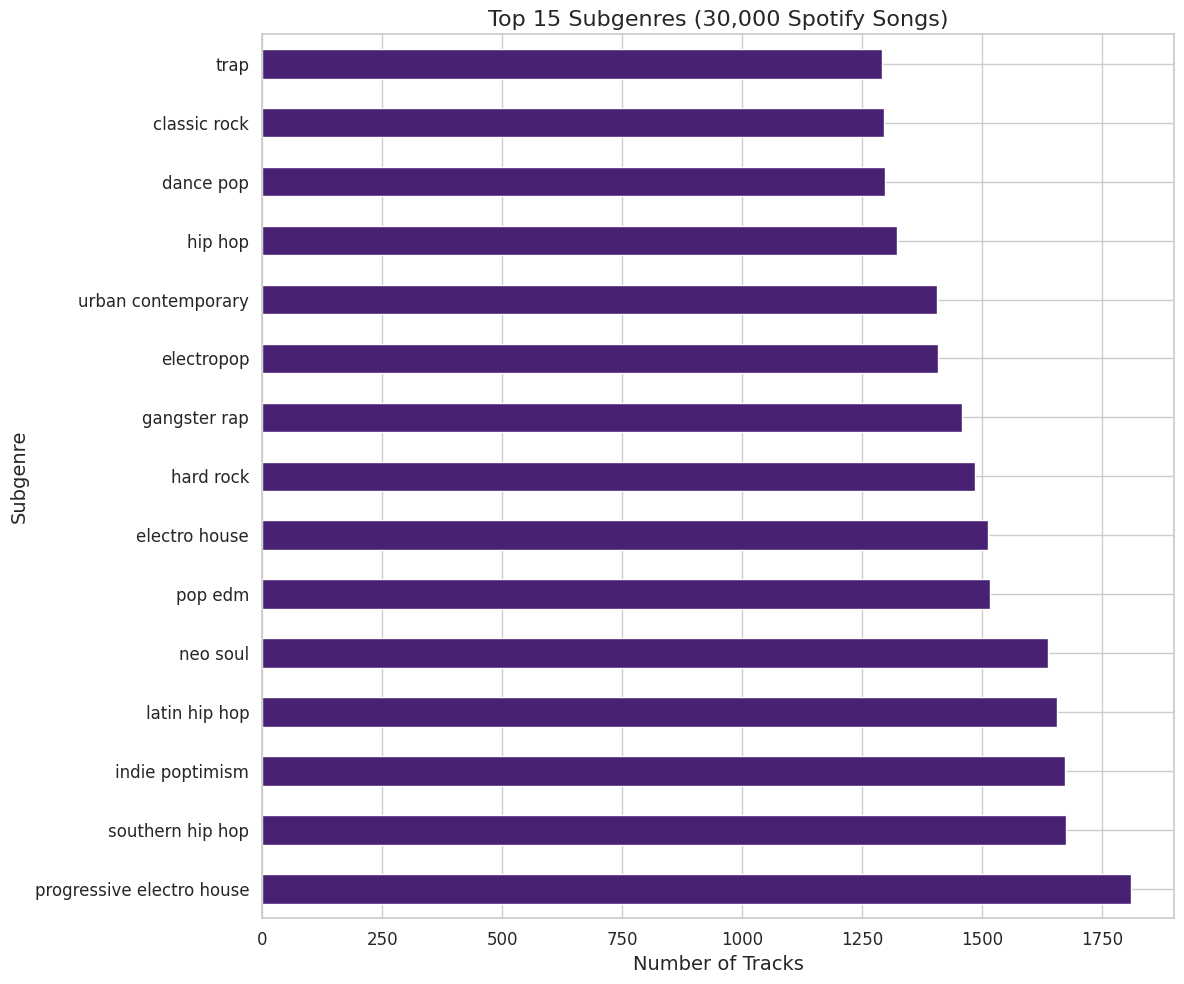

In [ ]:
# Subgenre analysis
if 'playlist_subgenre' in spotify_30k_clean.columns:
    # Get top subgenres
    subgenre_counts = spotify_30k_clean['playlist_subgenre'].value_counts().head(15)

    # Display top subgenres
    print("Top 15 Subgenres:")
    print(subgenre_counts)

    # Create horizontal bar chart
    plt.figure(figsize=(12, 10))
    subgenre_counts.plot(kind='barh')
    plt.title('Top 15 Subgenres (30,000 Spotify Songs)', fontsize=16)
    plt.xlabel('Number of Tracks', fontsize=14)
    plt.ylabel('Subgenre', fontsize=14)
    plt.tight_layout()
    plt.show()

## 5. Artist Success Analysis

Let's analyze what makes artists successful on Spotify.

### 5.1 Top Artists Visualization

Top 10 Artists by Average Popularity:
        track_artist       mean  count
9735   Trevor Daniel  97.000000      6
10242            Y2K  91.000000      7
2601     Don Toliver  90.714286      7
7959     Roddy Ricch  88.210526     19
2209          DaBaby  87.857143     14
5040            Kina  85.400000      5
4196        JACKBOYS  85.166667      6
10256      YNW Melly  84.600000     15
9031           Tainy  84.000000      6
5402   Lewis Capaldi  83.714286     21


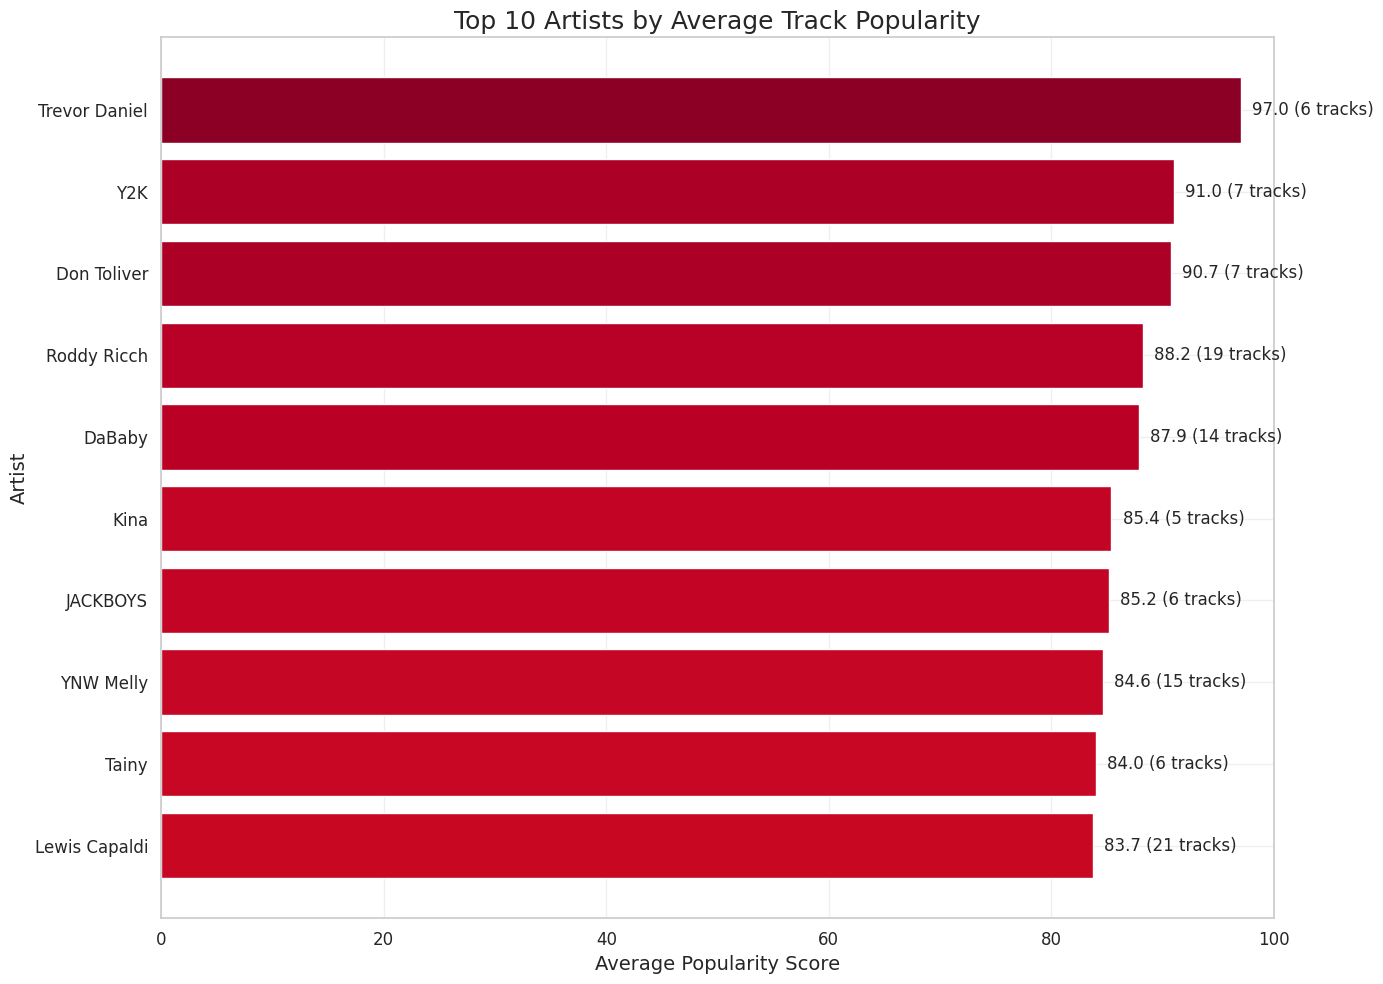

In [ ]:
# Top artists by popularity
if 'track_artist' in spotify_30k_df.columns and 'track_popularity' in spotify_30k_df.columns:
    # Get top 10 artists by average popularity
    top_artists = spotify_30k_df.groupby('track_artist')['track_popularity'].agg(['mean', 'count']).reset_index()
    top_artists = top_artists[top_artists['count'] >= 5]  # Filter to artists with at least 5 tracks
    top_artists = top_artists.sort_values('mean', ascending=False).head(10)

    # Display top artists
    print("Top 10 Artists by Average Popularity:")
    print(top_artists)

    # Create horizontal bar chart with gradient
    plt.figure(figsize=(14, 10))

    # Create color gradient based on popularity
    cmap = plt.cm.YlOrRd
    colors = cmap(top_artists['mean'] / 100)

    # Plot bars
    bars = plt.barh(top_artists['track_artist'], top_artists['mean'], color=colors)

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{top_artists["mean"].iloc[i]:.1f} ({top_artists["count"].iloc[i]} tracks)',
                va='center')

    plt.title('Top 10 Artists by Average Track Popularity', fontsize=18)
    plt.xlabel('Average Popularity Score', fontsize=14)
    plt.ylabel('Artist', fontsize=14)
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()  # Highest at the top
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Song Clustering Analysis

Let's cluster songs based on audio features to identify patterns.

In [ ]:
def cluster_songs(tracks_df, n_clusters=5):
    """Cluster songs based on audio features."""
    # Select audio features for clustering
    cluster_features = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'tempo']

    # Filter to tracks with all features available
    cluster_tracks = tracks_df.dropna(subset=cluster_features).copy()

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(cluster_tracks[cluster_features])

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_tracks['cluster'] = kmeans.fit_predict(scaled_features)

    # Calculate cluster centers
    cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                                  columns=cluster_features)

    # Add cluster labels
    cluster_centers['cluster'] = range(n_clusters)

    # Calculate cluster sizes
    cluster_sizes = cluster_tracks['cluster'].value_counts().sort_index()

    # Add cluster sizes to centers
    cluster_centers['size'] = cluster_sizes.values

    # Calculate average popularity per cluster if available
    if 'popularity' in cluster_tracks.columns:
        cluster_popularity = cluster_tracks.groupby('cluster')['popularity'].mean()
        cluster_centers['avg_popularity'] = cluster_popularity.values

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)

    # Add PCA results to tracks
    cluster_tracks['pca1'] = pca_result[:, 0]
    cluster_tracks['pca2'] = pca_result[:, 1]

    return cluster_tracks, cluster_centers, pca, scaler

# Sample tracks for clustering (for performance)
sample_size = 10000
if len(unified_tracks) > sample_size:
    tracks_sample = unified_tracks.sample(sample_size, random_state=42)
else:
    tracks_sample = unified_tracks

# Cluster songs
clustered_tracks, cluster_centers, pca, scaler = cluster_songs(tracks_sample)

# Display cluster centers
print("Cluster Centers:")
display(cluster_centers)

# Visualize clusters with enhanced styling
fig = px.scatter(clustered_tracks, x='pca1', y='pca2', color='cluster',
                hover_data=['name', 'artists', 'popularity', 'year'] \
                    if all(col in clustered_tracks.columns for col in ['name', 'artists', 'popularity', 'year']) \
                    else ['name'],
                title='Song Clusters Based on Audio Features',
                labels={'pca1': 'PCA Component 1', 'pca2': 'PCA Component 2', 'cluster': 'Cluster'},
                template='plotly_white',
                color_discrete_sequence=px.colors.qualitative.Bold,
                opacity=0.8)  # Add some transparency for better visualization

# Update layout with enhanced styling
fig.update_layout(
    height=700,
    width=1000,
    legend_title='Cluster',
    font=dict(family="Arial, sans-serif", size=14),
    title=dict(font=dict(size=20)),
    margin=dict(l=50, r=50, t=80, b=50),
    plot_bgcolor='white'
)

# Update marker size and add borders
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', zeroline=True, zerolinewidth=1.5, zerolinecolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', zeroline=True, zerolinewidth=1.5, zerolinecolor='gray')

fig.show()

Cluster Centers:


,danceability,energy,valence,acousticness,instrumentalness,tempo,cluster,size,avg_popularity
0,0.694838,0.658382,0.746019,0.311355,0.066123,111.710260,0,2988,31.565047
1,0.359461,0.208216,0.267041,0.855577,0.833351,104.466933,1,1426,14.617433
2,0.479290,0.282262,0.357013,0.773249,0.030347,105.226504,2,2342,22.305847
3,0.477523,0.751167,0.338129,0.081065,0.250053,116.423148,3,1845,31.960307
4,0.486535,0.674492,0.607047,0.282137,0.063685,164.863455,4,1391,30.518072


## 7. Popularity Prediction Model

Let's build a model to predict song popularity based on audio features.

In [ ]:
def build_popularity_prediction_model(tracks_df):
    """Build a model to predict song popularity based on audio features."""
    # Check if we have the necessary columns
    if 'popularity' not in tracks_df.columns:
        print("Warning: popularity column not found in tracks dataset")
        return None, None, None

    # Select features and target
    features = ['danceability', 'energy', 'key', 'loudness', 'mode',
               'speechiness', 'acousticness', 'instrumentalness',
               'liveness', 'valence', 'tempo']

    # Filter to tracks with all features and popularity available
    model_tracks = tracks_df.dropna(subset=features + ['popularity']).copy()

    # Add decade as a feature
    if 'decade' in model_tracks.columns:
        model_tracks['decade'] = model_tracks['decade'].astype('category')
        features.append('decade')

    # Prepare features and target
    X = pd.get_dummies(model_tracks[features], drop_first=True)
    y = model_tracks['popularity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Get feature importances
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return model, feature_importance, (X_test, y_test, y_pred)

# Build popularity prediction model
model, feature_importance, evaluation_data = build_popularity_prediction_model(unified_tracks)

# Display feature importances
if feature_importance is not None:
    print("\nFeature Importances:")
    display(feature_importance.head(10))

    # Plot feature importances with enhanced styling
    fig = px.bar(feature_importance.head(10), x='Importance', y='Feature',
                orientation='h',
                title='Top 10 Features for Predicting Song Popularity',
                labels={'Importance': 'Feature Importance', 'Feature': 'Audio Feature'},
                template='plotly_white',
                color='Importance',
                color_continuous_scale='viridis')

    # Update layout with enhanced styling
    fig.update_layout(
        height=500,
        width=900,
        yaxis={'categoryorder': 'total ascending'},
        font=dict(family="Arial, sans-serif", size=14),
        title=dict(font=dict(size=20)),
        margin=dict(l=50, r=50, t=80, b=50),
        plot_bgcolor='white'
    )

    # Update bar styling
    fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))

    # Add grid lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

    fig.show()

    # If we have evaluation data, plot actual vs predicted values
    if evaluation_data is not None:
        X_test, y_test, y_pred = evaluation_data

        # Create scatter plot of actual vs predicted values
        fig = px.scatter(x=y_test, y=y_pred,
                         title='Actual vs Predicted Popularity Scores',
                         labels={'x': 'Actual Popularity', 'y': 'Predicted Popularity'},
                         template='plotly_white',
                         opacity=0.7)

        # Add perfect prediction line
        fig.add_trace(go.Scatter(
            x=[min(y_test), max(y_test)],
            y=[min(y_test), max(y_test)],
            mode='lines',
            name='Perfect Prediction',
            line=dict(color='red', width=2, dash='dash')
        ))

        # Update layout with enhanced styling
        fig.update_layout(
            height=600,
            width=800,
            font=dict(family="Arial, sans-serif", size=14),
            title=dict(font=dict(size=20)),
            margin=dict(l=50, r=50, t=80, b=50),
            plot_bgcolor='white',
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )

        # Update marker styling
        fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))

        # Add grid lines
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

        fig.show()

Model Performance:
Mean Squared Error: 193.34
R² Score: 0.43

Feature Importances:


,Feature,Importance
4,acousticness,0.214945
2,loudness,0.111483
5,instrumentalness,0.076516
8,tempo,0.068950
3,speechiness,0.068054
1,energy,0.067813
7,valence,0.067423
0,danceability,0.066480
6,liveness,0.063843
30,decade_2010.0,0.051562


## 8. Decade Comparison Analysis

Let's compare music characteristics across different decades.

In [ ]:
def compare_decades(tracks_df, decades=None):
    """Compare audio features across different decades."""
    # Check if we have the necessary columns
    if 'decade' not in tracks_df.columns:
        print("Warning: decade column not found in tracks dataset")
        return None

    # Select decades to compare
    if decades is None:
        # Get decades with sufficient data
        decade_counts = tracks_df['decade'].value_counts()
        decades = decade_counts[decade_counts > 100].index.sort_values().tolist()

    # Filter to selected decades
    decade_tracks = tracks_df[tracks_df['decade'].isin(decades)].copy()

    # Select audio features
    features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
               'instrumentalness', 'liveness', 'valence', 'tempo']

    # Filter to features that exist
    features = [feat for feat in features if feat in decade_tracks.columns]

    # Create radar chart data
    radar_data = []

    # For each decade, calculate mean of each feature
    for decade in decades:
        decade_data = decade_tracks[decade_tracks['decade'] == decade][features].mean().to_dict()
        decade_data['decade'] = decade
        radar_data.append(decade_data)

    # Convert to DataFrame
    radar_df = pd.DataFrame(radar_data)

    # Normalize features to 0-1 scale for better comparison
    for feat in features:
        if feat == 'loudness':  # Special handling for loudness which is negative
            radar_df[feat] = (radar_df[feat] - radar_df[feat].min()) / (radar_df[feat].max() - radar_df[feat].min())
        else:
            radar_df[feat] = (radar_df[feat] - 0) / (1 - 0) if radar_df[feat].max() <= 1 else \
                            (radar_df[feat] - radar_df[feat].min()) / (radar_df[feat].max() - radar_df[feat].min())

    # Create radar chart with enhanced styling
    fig = go.Figure()

    # Define a vibrant color palette
    colors = px.colors.qualitative.Bold

    # Add traces for each decade with enhanced styling
    for i, decade in enumerate(decades):
        decade_row = radar_df[radar_df['decade'] == decade].iloc[0]

        fig.add_trace(go.Scatterpolar(
            r=[decade_row[feat] for feat in features],
            theta=features,
            fill='toself',
            name=f'{decade}s',
            line=dict(width=3, color=colors[i % len(colors)]),
            fillcolor=colors[i % len(colors)].replace('rgb', 'rgba').replace(')', ', 0.2)'),
            hovertemplate='%{theta}: %{r:.2f}<extra>' + f'{decade}s</extra>'
        ))

    # Update layout with enhanced styling
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1],
                tickfont=dict(size=12),
                gridcolor='lightgray',
                linecolor='gray'
            ),
            angularaxis=dict(
                tickfont=dict(size=14, family="Arial, sans-serif"),
                rotation=90,
                direction="clockwise",
                gridcolor='lightgray',
                linecolor='gray'
            ),
            bgcolor='white'
        ),
        title=dict(
            text='Comparison of Audio Features Across Decades',
            font=dict(size=20, family="Arial, sans-serif")
        ),
        height=700,
        width=900,
        template='plotly_white',
        legend=dict(
            font=dict(size=14, family="Arial, sans-serif"),
            orientation="h",
            yanchor="bottom",
            y=-0.1,
            xanchor="center",
            x=0.5
        ),
        margin=dict(l=80, r=80, t=100, b=100)
    )

    return fig, radar_df

# Compare decades
decades_to_compare = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
decade_comparison_fig, decade_comparison_data = compare_decades(unified_tracks, decades_to_compare)
decade_comparison_fig.show()